# Supported Vector Machine
- Normalization helped alot

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import wandb
import joblib
from pathlib import Path
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
# local
from analytics.gear_vibration.data_loader import load_data
from analytics.utils import log_metrics
from analytics.gear_vibration.analysis import sliding_window_features, check_correlation

In [2]:
data, df = load_data(path=Path('./data/gear_vibration'))

In [3]:
VERSION = '0.0.6'
CONFIG = {'window_size': 256, 'step_size': 128, 'version': VERSION, 'normalized': True}
model_name = f'svm_w_{CONFIG['window_size']}_v{VERSION}'
model_path = f'models/gear_vibration/support_vector_machine/{model_name}.pkl'
wandb.login()
wandb.init(project='iot_gear_vibration', name=model_name, id=model_name, resume='allow', config=CONFIG)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: joshoua-bigler (joshoua-bigler_) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Number of correlated features: 3
Correlated features: {'sensor1_rms', 'sensor2_ptp', 'sensor2_rms'}

Highly correlated feature pairs:
sensor1_rms and sensor1_mean: 1.00
sensor2_rms and sensor2_mean: 1.00
sensor2_ptp and sensor2_std: 0.96
Drop highly correlated features!


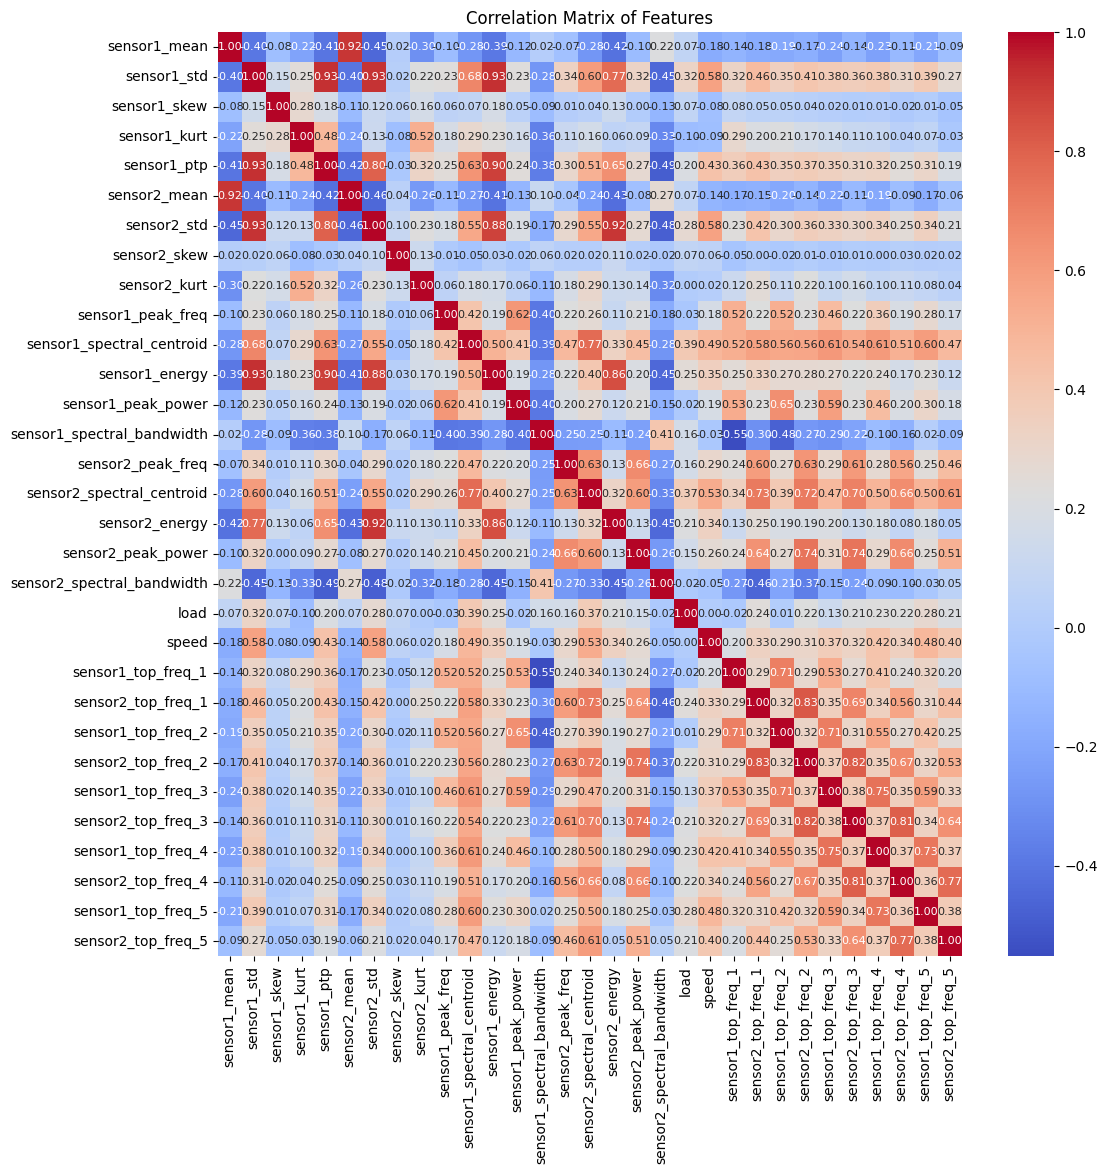

In [4]:
X, true_labels = sliding_window_features(df, CONFIG['window_size'], CONFIG['step_size'])
y, fault_code = pd.factorize(true_labels['fault'])

correlation_matrix = X.corr()
correlated_features, correlated_pairs = check_correlation(correlation_matrix=correlation_matrix, threshold=0.95)
print(f'Number of correlated features: {len(correlated_features)}')
print(f'Correlated features: {correlated_features}')

print('\nHighly correlated feature pairs:')
for feature1, feature2, corr_value in correlated_pairs:
  print(f'{feature1} and {feature2}: {corr_value:.2f}')
print('Drop highly correlated features!')
X = X.drop(correlated_features, axis=1)

correlation_matrix = X.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, annot_kws={'size': 8})
plt.title('Correlation Matrix of Features')
wandb.log({'correlation_matrix': wandb.Image(plt)})

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
n_features = X.shape[1]
if CONFIG['normalized']:
  scaler = StandardScaler()
  feature_names = list(X_train.columns)
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)
  X_train = pd.DataFrame(X_train, columns=feature_names)
  X_test = pd.DataFrame(X_test, columns=feature_names)

{'accuracy': 0.9287749287749287,
 'precision_macro': 0.9323498846317624,
 'recall_macro': 0.9286265093716194,
 'f1_macro': 0.9289717188815331,
 'precision_weighted': 0.9337024923596473,
 'recall_weighted': 0.9287749287749287,
 'f1_weighted': 0.9297355298718478}

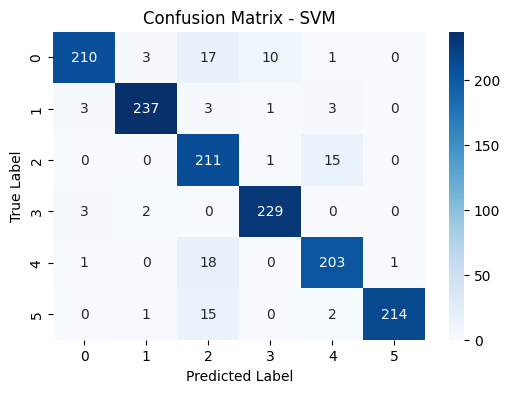

In [ ]:
svm_classifier = SVC(kernel='rbf', random_state=42, C=1.0) # rbf: Gaussian Kernel
svm_metadata = {'kernel': svm_classifier.kernel, 'C': svm_classifier.C, 'gamma': svm_classifier.gamma, 'degree': svm_classifier.degree}
svm_classifier.fit(X_train, y_train)
joblib.dump(svm_classifier, model_path)
artifact = wandb.Artifact(
  name=model_name,
  type='model',
  description='SVM model for gear vibration classification',
  metadata={**CONFIG, **svm_metadata}
)
artifact.add_file(model_path)
wandb.log_artifact(artifact)
# Evaluate the SVM classifier
y_pred = svm_classifier.predict(X_test)
metrics = log_metrics(y_test, y_pred)
for k, v in metrics.items():
  print(f'{k}: {v:.4f}')